# VAE Implementation for Frey Face Dataset using Keras/TensorFlow

In [13]:
# Install required packages if needed
!pip install numpy matplotlib tensorflow scipy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Setup and Imports

In [14]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import urllib.request

### 2. Parameters and Configuration

In [15]:
# Define key parameters for the model and training
BATCH_SIZE = 128
LATENT_DIM = 20  # Size of the latent space (embedding vector)
ORIGINAL_IMAGE_SHAPE = (28, 20)
ORIGINAL_IMAGE_DIM = np.prod(ORIGINAL_IMAGE_SHAPE)
EPOCHS = 200
LEARNING_RATE = 1e-3
DATASET_URL = "https://cs.nyu.edu/home/people/in_memoriam/roweis/data/frey_rawface.mat"
DATASET_FILENAME = "/data/input/q2/frey_rawface.mat"

### 3. Data Loading and Preprocessing

In [16]:
os.makedirs(os.path.dirname(DATASET_FILENAME), exist_ok=True)
# Download and load the Frey Face dataset
if not os.path.exists(DATASET_FILENAME):
    print("Downloading Frey Face dataset...")
    urllib.request.urlretrieve(DATASET_URL, DATASET_FILENAME)
    print("Download complete.")

# Load the .mat file
mat_data = scipy.io.loadmat(DATASET_FILENAME, squeeze_me=True, struct_as_record=False)
frey_faces = mat_data['ff'].T.astype('float32')

# Preprocess and normalize the data
frey_faces /= 255.0
frey_faces_flat = frey_faces.reshape(-1, ORIGINAL_IMAGE_DIM)

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(frey_faces_flat)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
print(f"Dataset shape: {frey_faces_flat.shape}")

Dataset shape: (1965, 560)


#### 4. VAE Model Definition

In [17]:
# (a) Sampling Layer for the Reparameterization Trick
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding an image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# (b) Encoder Network
h_dim = 256
encoder_inputs = keras.Input(shape=(ORIGINAL_IMAGE_DIM,))
x = layers.Dense(h_dim, activation="relu")(encoder_inputs)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# (c) Decoder Network
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(h_dim, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(ORIGINAL_IMAGE_DIM, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# (d) VAE Model connecting Encoder and Decoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= ORIGINAL_IMAGE_DIM
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 560)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    143,616 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 20)        │      5,140 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 20)        │      5,140 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 20)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153,896 (601.16 KB)

 Trainable params: 153,896 (601.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 560)            │       143,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,296 (583.19 KB)

 Trainable params: 149,296 (583.19 KB)

 Non-trainable params: 0 (0.00 B)

### 5. Training

In [18]:
print("Starting training...")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
vae.fit(dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
print("Training finished.")

Starting training...
Epoch 1/200
16/16 - 1s - 63ms/step - kl_loss: 1.5087 - loss: 368.6476 - reconstruction_loss: 367.1389
Epoch 2/200
16/16 - 0s - 3ms/step - kl_loss: 1.4421 - loss: 354.2386 - reconstruction_loss: 352.7964
Epoch 3/200
16/16 - 0s - 4ms/step - kl_loss: 1.0265 - loss: 352.6897 - reconstruction_loss: 351.6632
Epoch 4/200
16/16 - 0s - 4ms/step - kl_loss: 1.0078 - loss: 351.4720 - reconstruction_loss: 350.4642
Epoch 5/200
16/16 - 0s - 4ms/step - kl_loss: 1.0685 - loss: 350.0745 - reconstruction_loss: 349.0060
Epoch 6/200
16/16 - 0s - 4ms/step - kl_loss: 1.0238 - loss: 349.2800 - reconstruction_loss: 348.2562
Epoch 7/200
16/16 - 0s - 4ms/step - kl_loss: 1.0863 - loss: 348.3994 - reconstruction_loss: 347.3131
Epoch 8/200
16/16 - 0s - 3ms/step - kl_loss: 1.1126 - loss: 347.4030 - reconstruction_loss: 346.2904
Epoch 9/200
16/16 - 0s - 3ms/step - kl_loss: 1.1373 - loss: 346.7434 - reconstruction_loss: 345.6061
Epoch 10/200
16/16 - 0s - 3ms/step - kl_loss: 1.1564 - loss: 346.3700

### 6. Visualization of Reconstructed Images


Displaying original vs. reconstructed images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


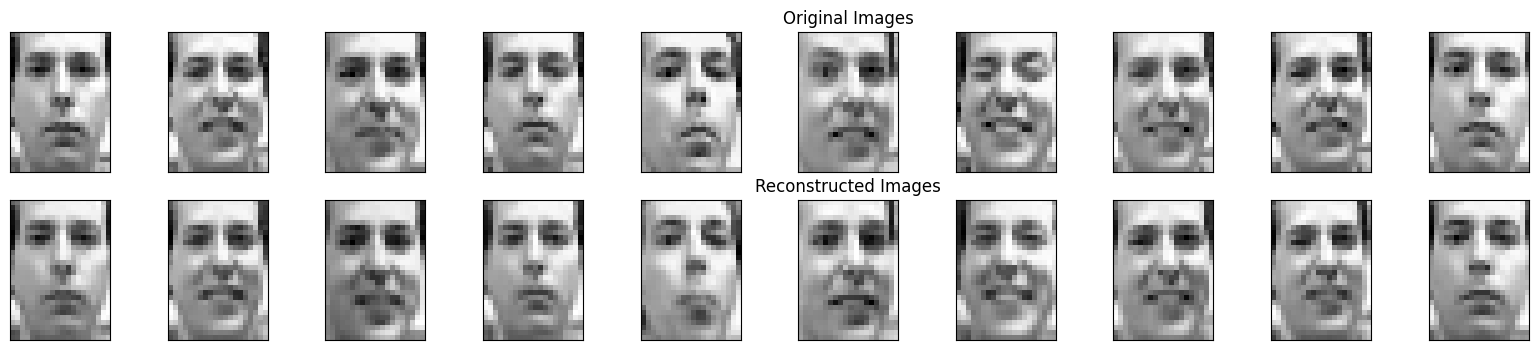

In [19]:
print("\nDisplaying original vs. reconstructed images...")

# Get the first 10 images from a batch
original_images_flat = next(iter(dataset))[:10]

# Get the reconstructed images from the VAE
_, _, z = vae.encoder.predict(original_images_flat)
reconstructed_images_flat = vae.decoder.predict(z)

# Reshape the flat images back to their original 28x20 shape for display
original_images = original_images_flat.numpy().reshape(-1, ORIGINAL_IMAGE_SHAPE[0], ORIGINAL_IMAGE_SHAPE[1])
reconstructed_images = reconstructed_images_flat.reshape(-1, ORIGINAL_IMAGE_SHAPE[0], ORIGINAL_IMAGE_SHAPE[1])

# Create a plot to display the images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images on the top row
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title("Original Images")

    # Display reconstructed images on the bottom row
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title("Reconstructed Images")
plt.show()


### 4. Sample from the Latent Space to Generate New Faces

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


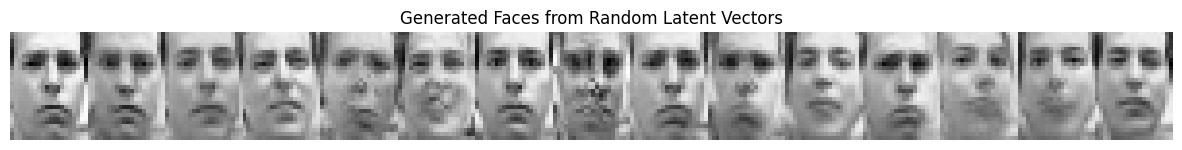

In [20]:
# This demonstrates that the VAE can generate novel faces.
n = 15  # Number of faces to generate
digit_size = (28, 20)
figure = np.zeros((digit_size[0], digit_size[1] * n))

# Sample points from the standard normal distribution (the prior)
grid_x = np.random.normal(size=(n, LATENT_DIM))

reconstructions = decoder.predict(grid_x)

for i in range(n):
    face = reconstructions[i].reshape(digit_size)
    figure[:, i * digit_size[1] : (i + 1) * digit_size[1]] = face

plt.figure(figsize=(15, 5))
plt.imshow(figure, cmap="gray")
plt.title("Generated Faces from Random Latent Vectors")
plt.axis('off')
plt.show()

### 5. Varying Latent Variables to Show Learned Features

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


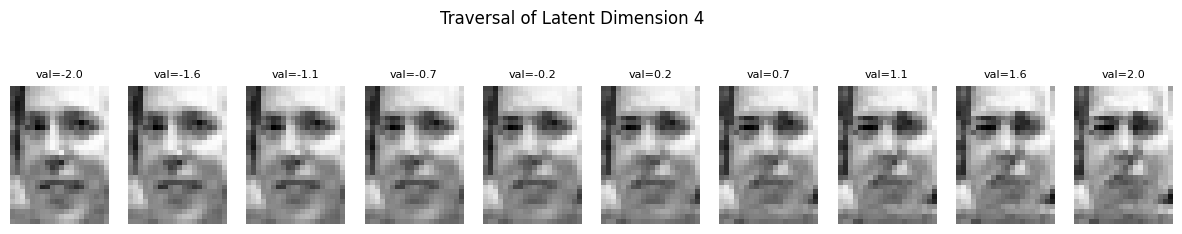

In [21]:
# This visualization traverses one latent dimension while keeping others constant
# to see what visual feature that dimension controls.

# Get the latent representation of a sample image
sample_image = frey_faces[np.random.choice(len(frey_faces))].reshape(1, -1)
z_mean, _, _ = encoder.predict(sample_image)

# Select a dimension to vary
latent_dim_to_vary = 4 # You can change this from 0 to 19
n_steps = 10
min_val, max_val = -2.0, 2.0 # Range of values for the traversal

# Create the figure to display results
fig, axes = plt.subplots(1, n_steps, figsize=(15, 3))

for i, val in enumerate(np.linspace(min_val, max_val, n_steps)):
    # Create a copy of the mean latent vector
    latent_vector = np.copy(z_mean)
    # Modify the chosen dimension
    latent_vector[0, latent_dim_to_vary] = val

    # Decode the modified latent vector
    decoded_image = decoder.predict(latent_vector)

    # Reshape and display the image
    ax = axes[i]
    ax.imshow(decoded_image.reshape(28, 20), cmap='gray')
    ax.set_title(f'val={val:.1f}', fontsize=8)
    ax.axis('off')

fig.suptitle(f'Traversal of Latent Dimension {latent_dim_to_vary}')
plt.show()